Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataset_path = '/content/drive/MyDrive/Computer Vision Project/Data Set'

In [ ]:
new_base_path = '/content/drive/MyDrive/Computer Vision Project/Organized Dataset'

# Mapping
categories = {
    'glass': ['brown-glass', 'green-glass', 'white-glass'],
    'organic': ['biological','organic'],
    'plastic': ['plastic'],
    'paper': ['cardboard', 'paper'],
    'metal': ['metal'],
    'trash': ['clothes', 'shoes', 'trash'],
    'ewaste': ['battery']
}

# Organize dataset
for waste_type, subcategories in categories.items():
    os.makedirs(os.path.join(new_base_path, waste_type), exist_ok=True)
    for subcategory in subcategories:
        subcategory_path = os.path.join(dataset_path, subcategory)
        if os.path.exists(subcategory_path):
            for file_name in os.listdir(subcategory_path):
                shutil.move(os.path.join(subcategory_path, file_name),
                            os.path.join(new_base_path, waste_type, file_name))

print("Dataset reorganized!")


Dataset reorganized!


In [ ]:
for root, dirs, files in os.walk(new_base_path):
    print(f"Directory: {root}, Number of files: {len(files)}")

Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset, Number of files: 0
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/glass, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/organic, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/plastic, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/metal, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/trash, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/ewaste, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/paper, Number of files: 2000


In [ ]:
def undersample_class(class_path, target_samples):
    files = os.listdir(class_path)
    if len(files) > target_samples:
        files_to_remove = random.sample(files, len(files) - target_samples)
        for file in files_to_remove:
            os.remove(os.path.join(class_path, file))
        print(f"Undersampled '{os.path.basename(class_path)}' to {target_samples} files.")

target_samples = 2000
# Undersample 'trash' class
trash_path = os.path.join(new_base_path, 'trash')
undersample_class(trash_path, target_samples)


In [ ]:
# Augmentation function
def augment_class(class_path, target_samples, augmenter):
    files = os.listdir(class_path)
    while len(files) < target_samples:
        file_to_augment = random.choice(files)
        image = Image.open(os.path.join(class_path, file_to_augment))
        image = image.convert("RGB")  # Ensure 3 channels
        image_array = np.array(image)
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        augmented_image = next(augmenter.flow(image_array, batch_size=1))[0]
        augmented_image = Image.fromarray(augmented_image.astype('uint8'))  # Convert back to PIL
        augmented_image.save(os.path.join(class_path, f"aug_{len(files)}.jpg"))
        files.append(f"aug_{len(files)}.jpg")
    print(f"Augmented '{os.path.basename(class_path)}' to {target_samples} files.")

# Data augmentation setup
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply balancing
for category in os.listdir(new_base_path):
    class_path = os.path.join(new_base_path, category)
    if os.path.isdir(class_path):
        files = os.listdir(class_path)
        if len(files) > target_samples:
            undersample_class(class_path, target_samples)
        elif len(files) < target_samples:
            augment_class(class_path, target_samples, augmenter)

In [ ]:
for root, dirs, files in os.walk(new_base_path):
    print(f"Directory: {root}, Number of files: {len(files)}")

Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset, Number of files: 0
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/glass, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/organic, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/plastic, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/metal, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/trash, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/ewaste, Number of files: 2000
Directory: /content/drive/MyDrive/Computer Vision Project/Organized Dataset/paper, Number of files: 2000


In [ ]:
train_path = '/content/drive/MyDrive/Computer Vision Project/Split/train'
val_path = '/content/drive/MyDrive/Computer Vision Project/Split/val'
test_path = '/content/drive/MyDrive/Computer Vision Project/Split/test'

# Create split directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate through each class folder
for class_name in os.listdir(new_base_path):
    class_path = os.path.join(new_base_path, class_name)
    if os.path.isdir(class_path):
        files = [os.path.join(class_path, f) for f in os.listdir(class_path)]

        # Split into train, validation, and test
        train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=0.33, random_state=42)

        # Function to copy files
        def copy_files(file_list, dest_folder):
            os.makedirs(os.path.join(dest_folder, class_name), exist_ok=True)
            for file in file_list:
                shutil.copy(file, os.path.join(dest_folder, class_name, os.path.basename(file)))

        # Copy files
        copy_files(train_files, train_path)
        copy_files(val_files, val_path)
        copy_files(test_files, test_path)

print("Dataset split completed!")

Dataset split completed!


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob

In [ ]:
x_data = []
y_data = []

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 2048/2048 [00:34<00:00, 59.88it/s] 


In [ ]:
from collections import Counter
Counter(y_data)

Counter({'glass': 3523,
         'organic': 2577,
         'plastic': 2391,
         'metal': 2322,
         'trash': 7663,
         'ewaste': 1985,
         'paper': 2048})

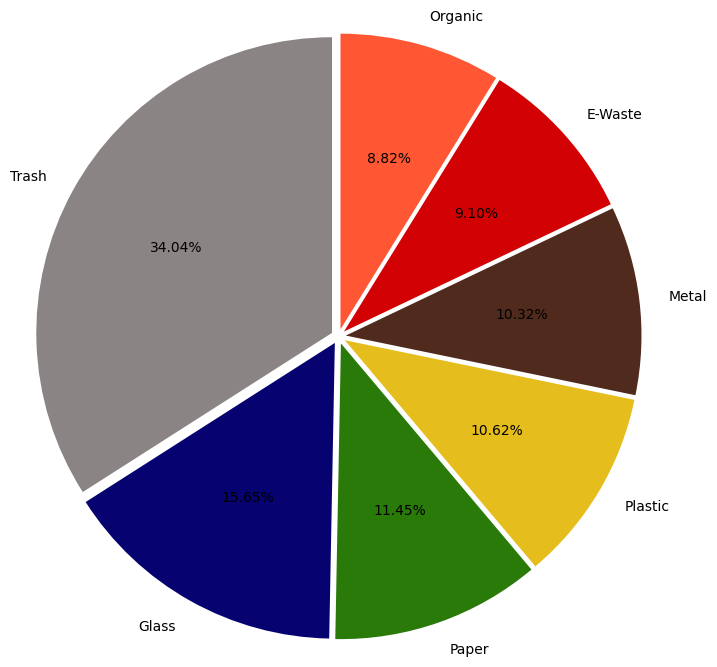

In [ ]:
colors = ['#8B8484','#060270', '#2A7A09', '#E5BD1D', '#502B1D',  '#D20103','#FF5733']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05]*7,autopct='%0.2f%%',
        labels=[ 'Trash','Glass','Paper', 'Plastic', 'Metal', 'E-Waste','Organic'], colors= colors,radius=2)
plt.show()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  7


#Convolutional Neural Network - CNN

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


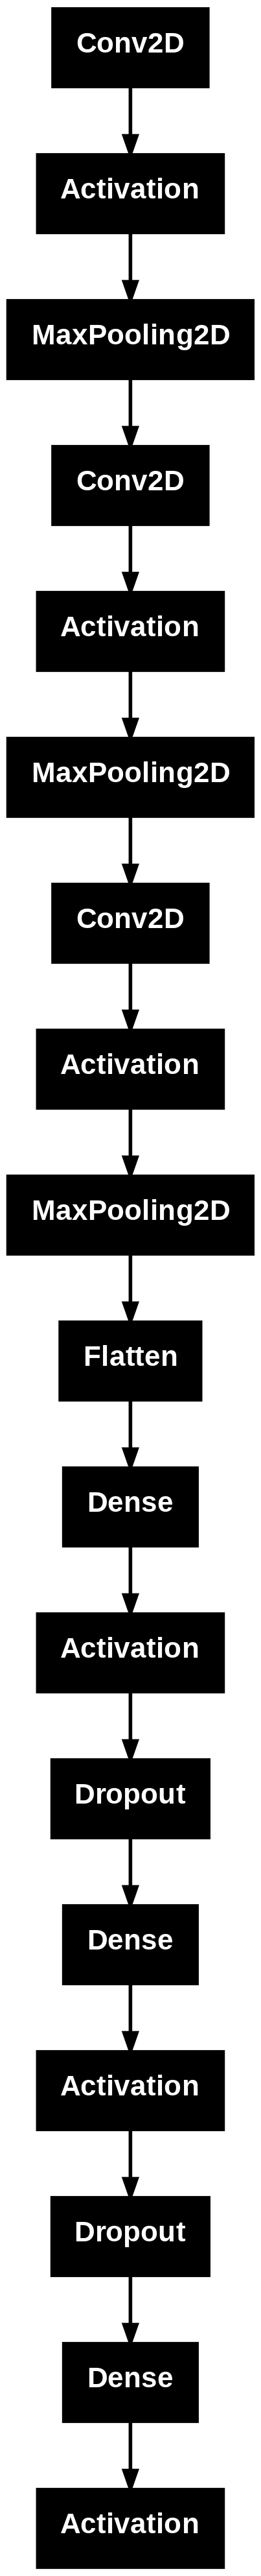

In [ ]:
plot_model(model)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 22509 images belonging to 7 classes.
Found 5629 images belonging to 7 classes.


In [ ]:
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 1568s 18s/step - accuracy: 0.2173 - loss: 0.5592 - val_accuracy: 0.5264 - val_loss: 0.2896
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.4633 - loss: 0.3398 - val_accuracy: 0.6316 - val_loss: 0.2373
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.5765 - loss: 0.2811 - val_accuracy: 0.7060 - val_loss: 0.2094
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.6653 - loss: 0.2350 - val_accuracy: 0.7968 - val_loss: 0.1566
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7392 - loss: 0.1932 - val_accuracy: 0.8364 - val_loss: 0.1246
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7951 - loss: 0.1589 - val_accuracy: 0.8707 - val_loss: 0.0995
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.8337 - loss: 0.1313 - val_accuracy: 0.9142 - val_loss: 0.0721
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8658 - loss: 0.1082 - val_accuracy: 0.9279 - val_loss: 

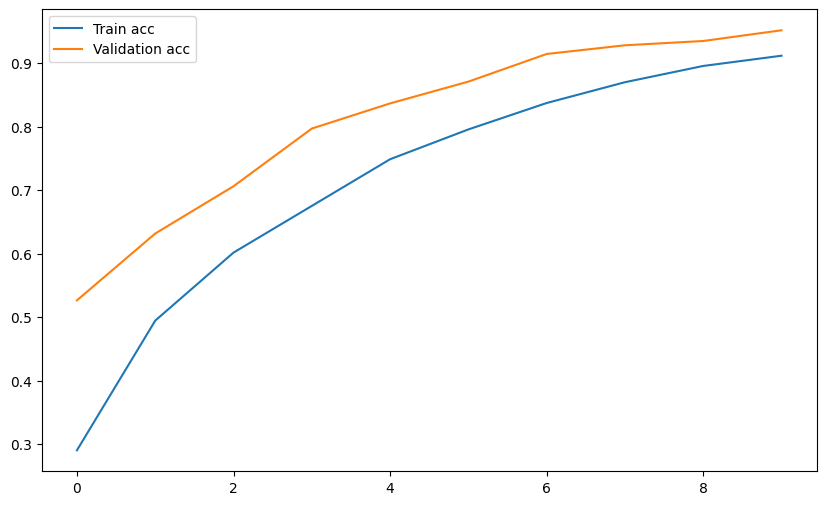

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

In [ ]:
def predict_func(img):
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


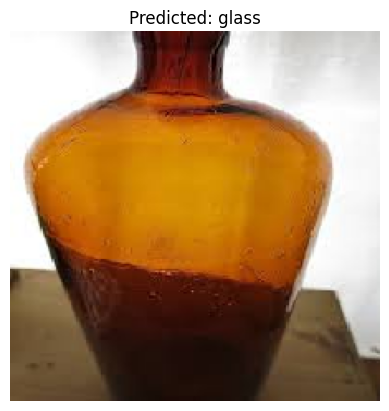

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load, preprocess, and predict
image = load_img('/content/drive/MyDrive/Computer Vision Project/Split/test/glass/brown-glass120.jpg', target_size=(224, 224))
image_array = np.expand_dims(img_to_array(image) / 255.0, axis=0)
predicted_label = list(train_generator.class_indices.keys())[np.argmax(model.predict(image_array))]

# Display the image with the prediction
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


Saving biological2.jpg to biological2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


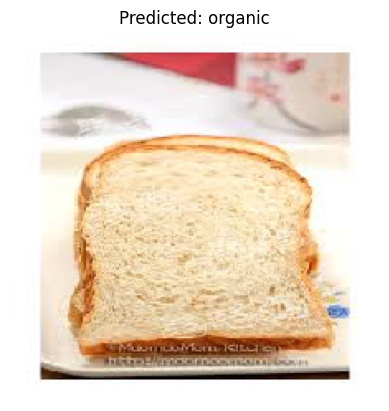

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

# Function to upload and predict
def upload_and_predict(model, class_indices):
    # Upload file
    uploaded = files.upload()
    for file_name in uploaded.keys():
        # Load and preprocess the image
        image = load_img(file_name, target_size=(224, 224))  # Adjust target_size as needed
        image_array = np.expand_dims(img_to_array(image) / 255.0, axis=0)

        # Predict the class
        prediction = model.predict(image_array)
        predicted_label = list(class_indices.keys())[np.argmax(prediction)]

        # Display the image and prediction
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

# Example usage
upload_and_predict(model, train_generator.class_indices)


Saving clothes7.jpg to clothes7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


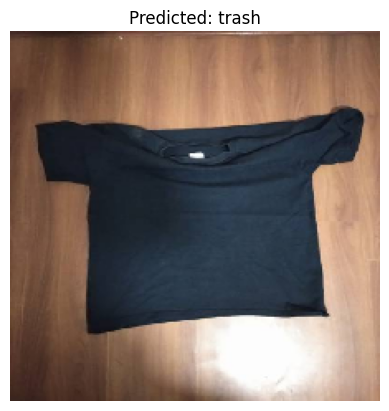

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

# Function to upload and predict multiple images
def upload_and_predict_multiple(model, class_indices):
    # Upload multiple files
    uploaded = files.upload()  # Opens a file upload dialog in Colab

    # Loop through each uploaded file
    for file_name in uploaded.keys():
        # Load and preprocess the image
        image = load_img(file_name, target_size=(224, 224))  # Adjust target_size to match your model
        image_array = np.expand_dims(img_to_array(image) / 255.0, axis=0)

        # Predict the class
        prediction = model.predict(image_array)
        predicted_label = list(class_indices.keys())[np.argmax(prediction)]

        # Display the image and prediction
        plt.figure()
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

# Example usage
upload_and_predict_multiple(model, train_generator.class_indices)


Saving plastic3.jpg to plastic3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


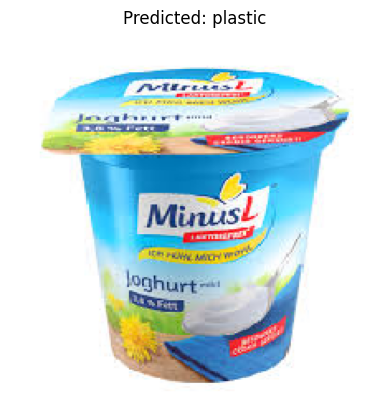

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

# Function to upload and predict
def upload_and_predict(model, class_indices):
    # Upload file
    uploaded = files.upload()
    for file_name in uploaded.keys():
        # Load and preprocess the image
        image = load_img(file_name, target_size=(224, 224))  # Adjust target_size as needed
        image_array = np.expand_dims(img_to_array(image) / 255.0, axis=0)

        # Predict the class
        prediction = model.predict(image_array)
        predicted_label = list(class_indices.keys())[np.argmax(prediction)]

        # Display the image and prediction
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

# Example usage
upload_and_predict(model, train_generator.class_indices)


Saving metal16.jpg to metal16.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


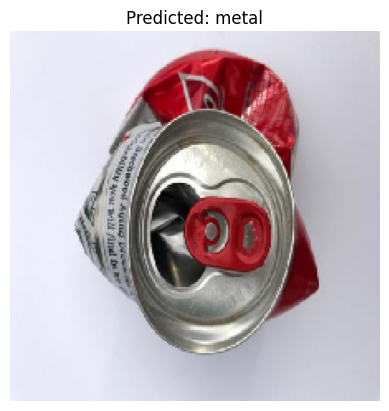

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files

# Function to upload and predict multiple images
def upload_and_predict_multiple(model, class_indices):
    # Upload files
    uploaded = files.upload()
    for file_name in uploaded.keys():
        try:
            # Load and preprocess the image
            image = load_img(file_name, target_size=(224, 224))  # Adjust target_size as needed
            image_array = np.expand_dims(img_to_array(image) / 255.0, axis=0)

            # Predict the class
            prediction = model.predict(image_array)
            predicted_label = list(class_indices.keys())[np.argmax(prediction)]

            # Display the image and prediction
            plt.imshow(image)
            plt.title(f"Predicted: {predicted_label}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

# Example usage
upload_and_predict_multiple(model, train_generator.class_indices)
